In [1]:
train_model = False

In [7]:
# https://github.com/jeffprosise/Applied-Machine-Learning/blob/main/Chapter%2013/Neural%20Machine%20Translation%20(LSTM).ipynb
# https://www.kaggle.com/datasets/dhruvildave/en-fr-translation-dataset?resource=download
import pandas as pd

df = pd.read_csv('data/en-fr.txt', names=['en', 'fr', 'attr'], usecols=['en', 'fr'], sep='\t')
# df = pd.read_csv('en-fr.csv', names=['en', 'fr'], usecols=['en', 'fr'], nrows=10000)
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)
df.head()

,en,fr
0,You're very clever.,Vous êtes fort ingénieuse.
1,Are there kids?,Y a-t-il des enfants ?
2,Come in.,Entrez !
3,Where's Boston?,Où est Boston ?
4,You see what I mean?,Vous voyez ce que je veux dire ?


In [8]:
import re
from unicodedata import normalize

def clean_text(text):
    text = normalize('NFD', str(text).lower())
    text = re.sub('[^A-Za-z ]+', '', text)
    return text

df['en'] = df['en'].apply(lambda row: clean_text(row))
df['fr'] = df['fr'].apply(lambda row: clean_text(row))
df.head()

,en,fr
0,youre very clever,vous etes fort ingenieuse
1,are there kids,y atil des enfants
2,come in,entrez
3,wheres boston,ou est boston
4,you see what i mean,vous voyez ce que je veux dire


In [9]:
df.shape

(50000, 2)

In [10]:
en = df['en']
fr = df['fr']

en_max_len = max(len(line.split()) for line in en)
fr_max_len = max(len(line.split()) for line in fr)

print(f'Max phrase length (English): {en_max_len}')
print(f'Max phrase length (French): {fr_max_len}')

Max phrase length (English): 7
Max phrase length (French): 14


In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(en)
en_sequences = en_tokenizer.texts_to_sequences(en)
en_x = pad_sequences(en_sequences, maxlen=en_max_len, padding='post')

fr_tokenizer = Tokenizer()
fr_tokenizer.fit_on_texts(fr)
fr_sequences = fr_tokenizer.texts_to_sequences(fr)
fr_y = pad_sequences(fr_sequences, maxlen=fr_max_len, padding='post')

In [12]:
en_vocab_size = len(en_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1

print(f'Vocabulary size (English): {en_vocab_size}')
print(f'Vocabulary size (French): {fr_vocab_size}')

Vocabulary size (English): 6033
Vocabulary size (French): 12195


In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, RepeatVector, TimeDistributed, Dropout

np.random.seed(42)
tf.random.set_seed(42)

model = Sequential()
model.add(Embedding(en_vocab_size, 256, mask_zero=True))
model.add(LSTM(256))
model.add(RepeatVector(fr_max_len))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.4))
model.add(TimeDistributed(Dense(fr_vocab_size, activation='softmax')))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary(line_length=100)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                      │ ?                               │       0 (unbuilt) │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ lstm (LSTM)                                │ ?                               │       0 (unbuilt) │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ repeat_vector (RepeatVector)               │ ?                               │       0 (unbuilt) │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ lstm_1 (LSTM)                              │ ?                               │       0 (unbuilt) │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout (Dropout)                          │ ?                               │       0 (unbuilt) │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ time_distributed (TimeDistributed)         │ ?                               │       0 (unbuilt) │
└────────────────────────────────────────────┴─────────────────────────────────┴───────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(en_x, fr_y, test_size=0.2, random_state=42)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.saving import load_model

if train_model is True:
    callback = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
    hist = model.fit(x_train, y_train, epochs=50, batch_size=50, validation_split=0.2, callbacks=[callback])
else:
    model = load_model('en-to-fr-translator.keras', custom_objects=None, compile=True, safe_mode=True)

[]

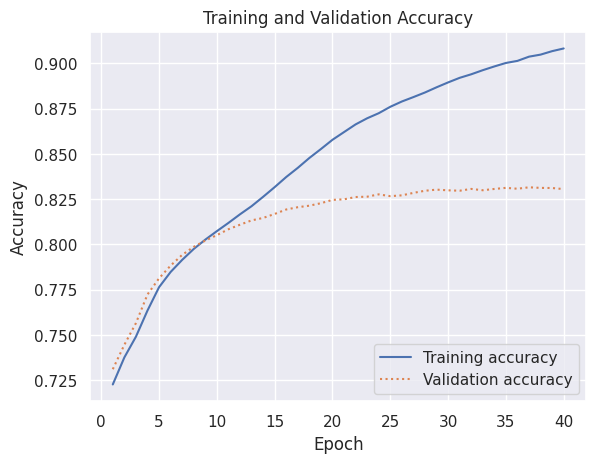

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

[]

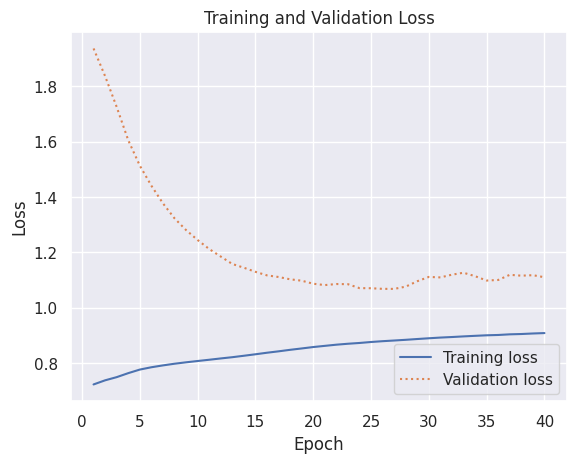

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

loss = hist.history['loss']
val = hist.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, '-', label='Training loss')
plt.plot(epochs, val, ':', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.plot()

In [16]:
def translate_text(text, model, en_tokenizer, fr_tokenizer, en_max_len):
    sequence = en_tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=en_max_len, padding='post')
    prediction = model.predict(padded_sequence, verbose=0)[0]
    indexes = [np.argmax(idx) for idx in prediction]
    return fr_tokenizer.sequences_to_texts([indexes])[0]

texts = en[40000:40010].values

for text in texts:
    translated = translate_text(text, model, en_tokenizer, fr_tokenizer, en_max_len)
    print(f'{text} => {translated}')

its fall now => cest lautomne maintenant maintenant
im losing => je suis en
it was quite funny => cetait plutot fait
thats not unusual => ce nest pas inhabituel
i think ill do that => je pense que je le ca
tom looks different => tom a lair different
its worth a try => ca vaut le coup
fortune smiled on him => la fortune la sourit
lets hit the road => allonsy
i love winning => jadore que


In [17]:
translate_text('Hello world', model, en_tokenizer, fr_tokenizer, en_max_len)

'salut'

In [36]:
len(x_test)
len(y_test)

from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

total_bleu_score = 0
for i in range(len(x_test)):
    en_input = en_tokenizer.sequences_to_texts([x_test[i]])[0]
    fr_reference = fr_tokenizer.sequences_to_texts([y_test[i]])[0]
    fr_prediction = translate_text(en_input, model, en_tokenizer, fr_tokenizer, en_max_len)
    total_bleu_score += sentence_bleu([fr_reference.split()], fr_prediction.split(), smoothing_function=SmoothingFunction().method4)

total_bleu_score

1798.53574380535

In [38]:
average_bleu_score = total_bleu_score/(len(y_test))
average_bleu_score

0.179853574380535

In [ ]:
from bert_score import score

refs = [fr_tokenizer.sequences_to_texts([y_test[i]])[0] for i in range(len(x_test))]
cands = [translate_text(en_tokenizer.sequences_to_texts([x_test[i]])[0], model, en_tokenizer, fr_tokenizer, en_max_len) for i in range(len(x_test))]

In [42]:
P, R, F1 = score(cands, refs, lang='fr', verbose=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/266 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/157 [00:00<?, ?it/s]

done in 132.44 seconds, 75.51 sentences/sec


In [44]:
print(f"System level F1 score: {F1.mean():.3f}")
print(f"System level Precision score: {P.mean():.3f}")
print(f"System level Recall score: {R.mean():.3f}")

System level F1 score: 0.821
System level Precision score: 0.830
System level Recall score: 0.813


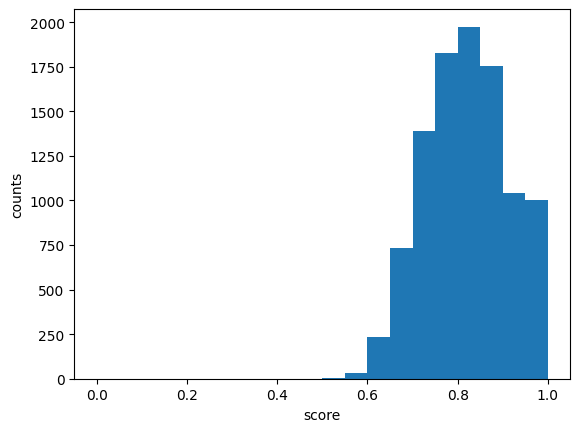

In [45]:
import matplotlib.pyplot as plt
plt.hist(F1, bins=20)
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

In [53]:
from torchmetrics.text import TranslationEditRate
from torchmetrics.functional.text import translation_edit_rate

metric = TranslationEditRate()
reference_values = []
for i in range(len(cands)):
    reference_values.append([refs[i]])

translation_edit_rate(cands, reference_values)

tensor(0.5461)

In [55]:
comet_data = []
for i in range(len(x_test)):
    comet_data.append({
        "src": en_tokenizer.sequences_to_texts([x_test[i]])[0],
        "mt": cands[i],
        "ref": refs[i]
    })
comet_data

[{'src': 'i pretended to work',
  'mt': 'jai fait semblant de travailler',
  'ref': 'je fis semblant de travailler'},
 {'src': 'what did you learn', 'mt': 'quavezvous', 'ref': 'quastu appris'},
 {'src': 'he will be back soon',
  'mt': 'il sera bientot',
  'ref': 'il reviendra rapidement'},
 {'src': 'was there a fire', 'mt': 'y un un', 'ref': 'y avaitil un feu'},
 {'src': 'youre drunk', 'mt': 'tu es saoul', 'ref': 'tu es saoule'},
 {'src': 'dont hang up', 'mt': 'ne quitte pas', 'ref': 'ne raccroche pas'},
 {'src': 'they both died',
  'mt': 'elles sont morts morts',
  'ref': 'ils sont morts tous les deux'},
 {'src': 'i have a toothache',
  'mt': 'jai un aux dents',
  'ref': 'jai mal aux dents'},
 {'src': 'thats right', 'mt': 'cest juste', 'ref': 'cest ca'},
 {'src': 'did you take a shower',
  'mt': 'astu un un un',
  'ref': 'astu pris une douche'},
 {'src': 'turn it off', 'mt': 'augmentezle', 'ref': 'eteinsle'},
 {'src': 'do you have a copy',
  'mt': 'avezvous avezvous une copie',
  'ref

In [59]:
from comet import download_model, load_from_checkpoint

comet_model_path = download_model("Unbabel/wmt22-comet-da")
comet_model = load_from_checkpoint(comet_model_path)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

hparams.yaml:   0%|          | 0.00/567 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

LICENSE:   0%|          | 0.00/9.69k [00:00<?, ?B/s]

checkpoints/model.ckpt:   0%|          | 0.00/2.32G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.53k [00:00<?, ?B/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Encoder model frozen.
/Users/enyiomaosondu/personal/final-year-project/env/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


In [62]:
model_output = comet_model.predict(comet_data, batch_size=8)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/enyiomaosondu/personal/final-year-project/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [23:30<00:00,  1.13s/it]


In [65]:
model_output.system_score

0.6879038995295763

In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score


y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=-1)
y_pred_classes_flat = y_pred_classes.flatten()
y_test_flat = y_test.flatten()

precision = precision_score(y_test_flat, y_pred_classes_flat, average='weighted')
recall = recall_score(y_test_flat, y_pred_classes_flat, average='weighted')
f1 = f1_score(y_test_flat, y_pred_classes_flat, average='weighted')

print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Precision: 0.8120492907951196, Recall: 0.83255, F1-Score: 0.8183863976601378


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [44]:
model.save('en-to-fr-translator.keras')